In [32]:
!pip install transformers
!pip install pydot
!pip install pickle

python(13226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


python(13227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


python(13228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [1]:
import pandas as pd
# Load the dataset
file_path = r'../data/preprocessing/preprocessed.csv'
df_preprocessed = pd.read_csv(file_path)
df_preprocessed.head()

,Title,Subreddit,Author,Likes,Comments,Sentiment,num_words,Processed_Title
0,Texas Supreme Court Rules Against Woman Who So...,news,Lifeboatb,7231,912,0,10,texas supreme court rule woman sought abortion
1,Texas woman who sought court permission for ab...,news,11-110011,24560,2327,0,15,texas woman sought court permission abortion l...
2,Home Alone star gets life-saving cancer surger...,news,ILikeTalkn2Myself,8341,499,0,11,home alone star get cancer surgery raised online
3,Russian opposition leader Navalny missing from...,news,agnesiswitch,12825,742,0,10,russian opposition leader navalny missing pris...
4,Special counsel goes directly to Supreme Court...,news,hamsterberry,5294,484,0,15,special counsel go directly supreme court reso...


In [2]:
from sklearn.model_selection import train_test_split
# Split the dataframe into dfx_train and dfx_test

dfx_train, dfx_test = train_test_split(
    df_preprocessed, test_size=0.2, random_state=42)
y = df_preprocessed['Sentiment']

print(dfx_train.shape)
print(dfx_test.shape)

(4517, 8)
(1130, 8)


In [3]:
from keras.utils import to_categorical
to_categorical(dfx_train['Sentiment'])

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [4]:
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

2023-12-12 09:50:31.136273: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-12 09:50:31.136305: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-12 09:50:31.136313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-12 09:50:31.136771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 09:50:31.137124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationshi

#### Use the pretrained model


In [5]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.utils import to_categorical

In [6]:
# Replace NaN values in 'Processed_Title' column with empty string
dfx_train['Processed_Title'] = dfx_train['Processed_Title'].fillna(
    '').astype(str)
dfx_test['Processed_Title'] = dfx_test['Processed_Title'].fillna(
    '').astype(str)

In [7]:
dfx_train['num_words'].max()

62

<p> The first and last tokens are always unique and indicates the start and end point</p>
<p> The tokenizer will automatically truncate the sequence if it is longer than 70 tokens. </p>


<p> truncation=True, # if the sentence is longer than max_length, it will be truncated to max_length </p>
<p> padding=True, # it will pad the sentences to fit the max_length </p>
<p> return_tensors='tf', # it will return TensorFlow tensors </p>
<p> return_token_type_ids = False, # we don't want token type ids </p>
<p> return_attention_mask = True, # the performance will be better if we include attention masks </p>
<p> verbose = True # it will print the progress bar </p>


In [8]:
X_train = tokenizer(
    text=dfx_train['Processed_Title'].to_list(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length',  # change this line
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=dfx_test['Processed_Title'].to_list(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length',  # and this line
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [9]:
X_train

{'input_ids': <tf.Tensor: shape=(4517, 70), dtype=int32, numpy=
array([[  101, 15034,  2360, ...,     0,     0,     0],
       [  101, 22625,  2440, ...,     0,     0,     0],
       [  101,  2605, 19428, ...,     0,     0,     0],
       ...,
       [  101,  2393,  1043, ...,     0,     0,     0],
       [  101,  3241,  2635, ...,     0,     0,     0],
       [  101,  8326,  3277, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4517, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [10]:
import tensorflow as tf
from keras.layers import Input, Dense

max_len = 70  # define the maximum length of a sequence

# the input layer will have two inputs (input_ids and attention_mask)

input_ids = Input(shape=(max_len, ), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len, ), dtype=tf.int32, name="attention_mask")

# bert model will contain the inputs and the output will be the last hidden state
embeddings = bert(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
# the output layer will have 3 neurons for the 3 classes, we use sigmoid to get the probabilities
y = Dense(3, activation='sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True  # we will train the bert model

In [11]:
model.layers

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 70)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 70, 76                                       

In [13]:
optimizer = Adam(
    learning_rate=5e-06,  # learning rate for the bert model
    epsilon=1e-08,  # epsilon parameter prevents any division by zero
    weight_decay=0.01,  # weight decay to prevent overfitting
    clipnorm=1.0  # gradient clipping
)


# Define the loss function and accuracy metric
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


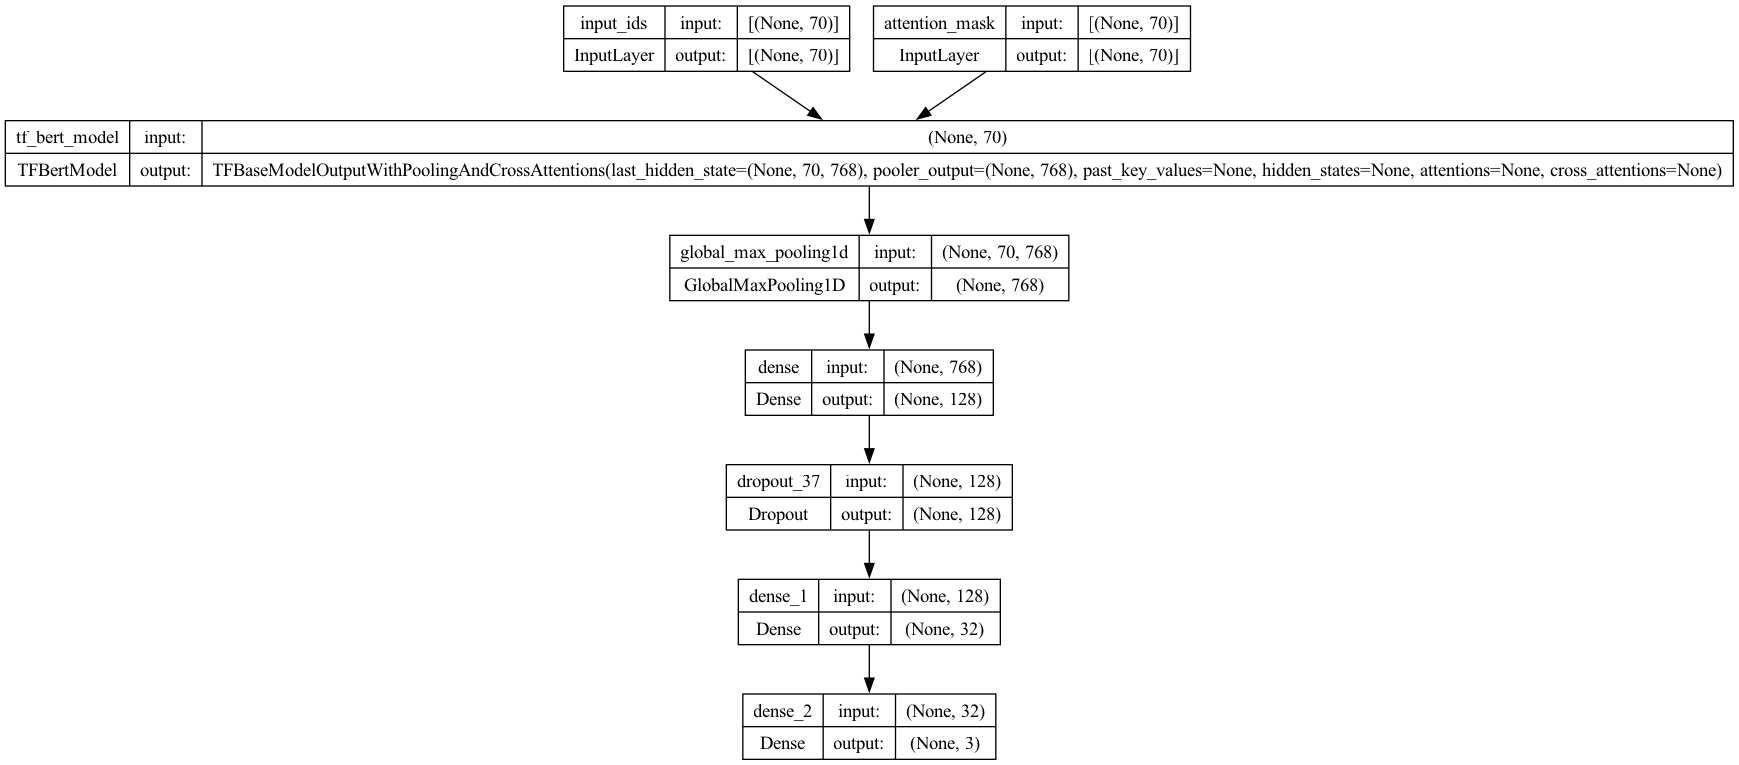

In [14]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [15]:
train_history = model.fit(
    x={'input_ids':X_train['input_ids'],'attention_mask':X_train['attention_mask']},
    y = to_categorical(dfx_train['Sentiment']), 
    validation_data = ({'input_ids' : X_test['input_ids'],'attention_mask':X_test['attention_mask']}, to_categorical(dfx_test['Sentiment'])),
    epochs=1,
    batch_size=36
)

/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2023-12-12 09:50:48.989757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 1391s 11s/step - loss: 0.9268 - balanced_accuracy: 0.5541 - val_loss: 0.7102 - val_balanced_accuracy: 0.6540


In [16]:
# The weights should be saved and then and then we need to make the same model architecture and then load with the weights
model.save_weights('sentiment_weights.h5')

In [17]:
model.load_weights('sentiment_weights.h5')

In [18]:
model.save('sentiment_model.h5')

/Users/diegobolanos/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import pickle

# pickle.dump(model,open('model.pkl','wb'))
# model=pickle.load(open('model.pkl','rb'))

### Prediction


In [19]:
predicted_raw = model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})

36/36 [==============================] - 38s 702ms/step


In [20]:
# this will represent our 3 classes (negative, neutral, positive)
predicted_raw[0]

array([0.82157046, 0.07799823, 0.7463869 ], dtype=float32)

In [21]:
import numpy as np
y_predicted = np.argmax(predicted_raw, axis=1)

In [22]:
dfx_test['Sentiment']

4996    0
4351    2
3080    0
2835    2
1197    2
       ..
3478    0
4510    2
1609    0
2572    0
897     0
Name: Sentiment, Length: 1130, dtype: int64

In [23]:
from sklearn.metrics import classification_report
print(classification_report(dfx_test['Sentiment'], y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       673
           1       0.00      0.00      0.00        23
           2       0.55      0.65      0.60       434

    accuracy                           0.65      1130
   macro avg       0.43      0.44      0.44      1130
weighted avg       0.65      0.65      0.65      1130



In [28]:
texts = input('Enter your text: ')

val_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,  # it will pad the sentences to fit the max_length
    return_tensors='tf',  # it will return TensorFlow tensors
    return_token_type_ids=False,  # we don't want token type ids
    # the performance will be better if we include attention masks
    return_attention_mask=True,
    verbose=True  # it will print the progress bar
)

In [29]:
validation = model.predict(
    {'input_ids': val_val['input_ids'], 'attention_mask': val_val['attention_mask']})*100
validation

1/1 [==============================] - 9s 9s/step


array([[45.809467, 11.325269, 52.77086 ]], dtype=float32)

In [30]:
encode_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [31]:
for key, value in zip(encode_dict.keys(), validation[0]):
    print(f'{key}: {value}')

0: 45.80946731567383
1: 11.325268745422363
2: 52.77085876464844
